In [15]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# FMCW Radar Link Budget Analysis (Mesh Target)

## Introduction

This notebook demonstrates **RadarSimPy's mesh target simulation capabilities** and validates simulation accuracy by comparing results with theoretical link budget calculations. Using 3D mesh models (STL files), RadarSimPy accurately computes radar returns from complex geometries.

**What You'll Learn:**

- Use RadarSimPy's `Transmitter`, `Receiver`, and `Radar` classes to configure FMCW systems
- Load 3D mesh models (STL format) as radar targets
- Run electromagnetic simulations with `sim_radar()`
- Process simulated baseband data using RadarSimPy's signal processing functions
- **Validate simulation accuracy**: Compare RadarSimPy's output with theoretical SNR calculations

**Key RadarSimPy Features Demonstrated:**

- **Mesh-based RCS modeling**: Automatic RCS computation from 3D geometry
- **Physics-based simulation**: Full electromagnetic modeling of radar-target interaction
- **High-fidelity results**: Simulation matches theoretical predictions within fractions of a dB

**Why This Matters:** Before building hardware, you can use RadarSimPy to accurately predict radar performance and validate system designs against theoretical models.

### What is FMCW Radar?

**FMCW (Frequency Modulated Continuous Wave)** radar continuously transmits a signal whose frequency increases linearly over time (called a "chirp"). When the transmitted signal reflects off a target and returns to the receiver, it has a slight frequency difference compared to the currently transmitted frequency. This frequency difference (called the "beat frequency") is proportional to the target's range.

**Key Advantages:**

- Simultaneously measures range and velocity
- Lower peak power requirements compared to pulsed radar
- High range resolution achievable with wide bandwidth
- Commonly used in automotive radar (76-81 GHz band)

## Theoretical Reference for Validation

To validate RadarSimPy's simulation accuracy, we'll use the radar range equation to calculate expected SNR. The simulation should match these theoretical predictions.

### Radar Range Equation

$$
P_r = \frac{P_t G_t G_r \lambda^2 \sigma}{(4\pi)^3 R^4 L_s}
$$

Where:

- $P_t$ = **Transmitted power** (W)
- $G_t$ = **Transmitting antenna gain**
- $G_r$ = **Receiving antenna gain**
- $\lambda$ = **Wavelength** of the radar signal (m), $\lambda = \frac{c}{f}$ where $c$ is the speed of light (3×10⁸ m/s) and $f$ is the frequency (Hz)
- $\sigma$ = **Radar cross-section (RCS)** of the target (m²)
- $R$ = **Range** to the target (m)
- $L_s$ = **System losses**, including propagation losses, hardware inefficiencies, and atmospheric attenuation

### 1. Transmitted Power $(P_t)$:

The radar system transmits a signal with power $P_t$ (in watts). This power is directed through the radar's transmitting antenna, which has a specific gain $G_t$, concentrating the energy into a particular direction.

$$
P_{\text{transmit}} = P_t G_t
$$

### 2. Antenna Gain $(G_t)$ and $(G_r)$:

Antenna gain is a measure of how well the antenna focuses the transmitted (or received) energy in a specific direction. It is typically expressed as:

$$
G = \frac{4 \pi A_{\text{antenna}}}{\lambda^2}
$$

Where $A_{\text{antenna}}$ is the effective area of the antenna, and $\lambda$ is the wavelength.

### 3. Free-Space Path Loss (FSPL):

As the signal propagates through space, it experiences **free-space path loss (FSPL)**, which increases with the square of the distance from the radar and the square of the operating frequency. The FSPL is given by:

$$
L_{\text{fspl}} = \left( \frac{4 \pi R}{\lambda} \right)^2 = \frac{(4 \pi R f)^2}{c^2}
$$

Where:

- $R$ is the distance to the target (m)
- $f$ is the radar frequency (Hz)
- $c$ is the speed of light (3×10⁸ m/s)

### 4. Radar Cross Section (RCS) $( \sigma )$:

The radar cross-section $\sigma$ represents how much of the transmitted signal is reflected back by the target. Larger or more reflective targets have a higher RCS, which increases the power of the reflected signal:

$$
P_{\text{return}} = P_{\text{transmit}} \frac{\sigma}{4 \pi R^2}
$$

### 5. Received Power $(P_r)$:

The power received by the radar after the signal is reflected from the target is determined by the radar range equation:

$$
P_r = \frac{P_t G_t G_r \lambda^2 \sigma}{(4\pi)^3 R^4 L_s}
$$

- $R^4$: The signal experiences two-way propagation, so the range term is raised to the fourth power — $R^2$ for the transmission from radar to the target and another $R^2$ for the return path.
- $L_s$: This term represents **total system losses**, which can include:
  - Propagation losses (e.g., due to atmospheric absorption).
  - Antenna losses (e.g., due to inefficiencies in the antenna design).
  - Polarization mismatches and other hardware inefficiencies.

### 6. Noise Power $(P_{\text{noise}})$:

For the radar system to successfully detect a target, the received power $P_r$ must exceed the **minimum detectable signal (MDS)**, $P_{\text{min}}$, which is defined by the receiver sensitivity and the noise level in the system:

$$
P_{\text{noise}} = k T B F
$$

Where:

- $k$ = **Boltzmann's constant** (1.38×10⁻²³ J/K)
- $T$ = **System temperature** (Kelvin)
- $B$ = **Receiver bandwidth** (Hz)
- $F$ = **Receiver noise figure**

### 7. Signal-to-Noise Ratio $(SNR)$:

The **signal-to-noise ratio $(SNR)$** is a key performance metric that determines whether the target can be detected reliably. A higher SNR means the signal is strong compared to the noise, making detection easier.

$$
SNR = \frac{P_r}{P_{\text{noise}}}
$$

**We'll use these equations to validate RadarSimPy's simulation results later in this notebook.**

## Configure RadarSimPy Radar System

### System Parameters

We'll configure a radar system in RadarSimPy with these specifications:

#### Transmitter

- $P_t = 13$ dBm
- $G_t = 12$ dB
- $N_p = 512$ (number of pulses)

#### Receiver

- $f_s = 20 \times 10^6$ (sampling rate)
- $N_s = 1024$ (number of samples per pulse)
- $G_r = 12$ dB
- $\lambda = 3e8/76.5e9$ m
- $F = 11$ dB

#### Target

- A trihedral corner reflector, 13.6 dBsm @ 76.5 GHz
- $R = 100$ m

### Build Simulation Model

In [16]:
import numpy as np
import scipy.constants as sci_const
from radarsimpy import Radar, Transmitter, Receiver

#### Antenna Configuration

We define the antenna characteristics using synthetic patterns. The antenna gain is set to 12 dB.

To model the directional behavior:
- **Azimuth (Horizontal)**: We use a $\cos^4(\theta)$ pattern.
- **Elevation (Vertical)**: We use a narrower $\cos^{20}(\phi)$ pattern.

These patterns approximate a real radar antenna that focuses energy more tightly in elevation than in azimuth.

In [17]:
# Define antenna gain in dB
antenna_gain = 12

# Generate azimuth angle pattern from -80° to +80°
az_angle = np.arange(-80, 81, 1)
# Azimuth pattern: cos^4 gives a narrower beamwidth in horizontal plane
az_pattern = 20 * np.log10(np.cos(az_angle / 180 * np.pi) ** 4) + antenna_gain

# Generate elevation angle pattern from -80° to +80°
el_angle = np.arange(-80, 81, 1)
# Elevation pattern: cos^20 gives a much narrower beamwidth in vertical plane
el_pattern = 20 * np.log10((np.cos(el_angle / 180 * np.pi)) ** 20) + antenna_gain

#### Antenna Pattern Visualization

The antenna patterns define how the radar focuses its energy in different directions:

- **Azimuth pattern** (horizontal plane): Wider beam allows coverage across a broader horizontal field of view
- **Elevation pattern** (vertical plane): Narrower beam provides better vertical resolution

Note the dB scale: -3 dB represents the half-power beamwidth, where the antenna gain is reduced by half.


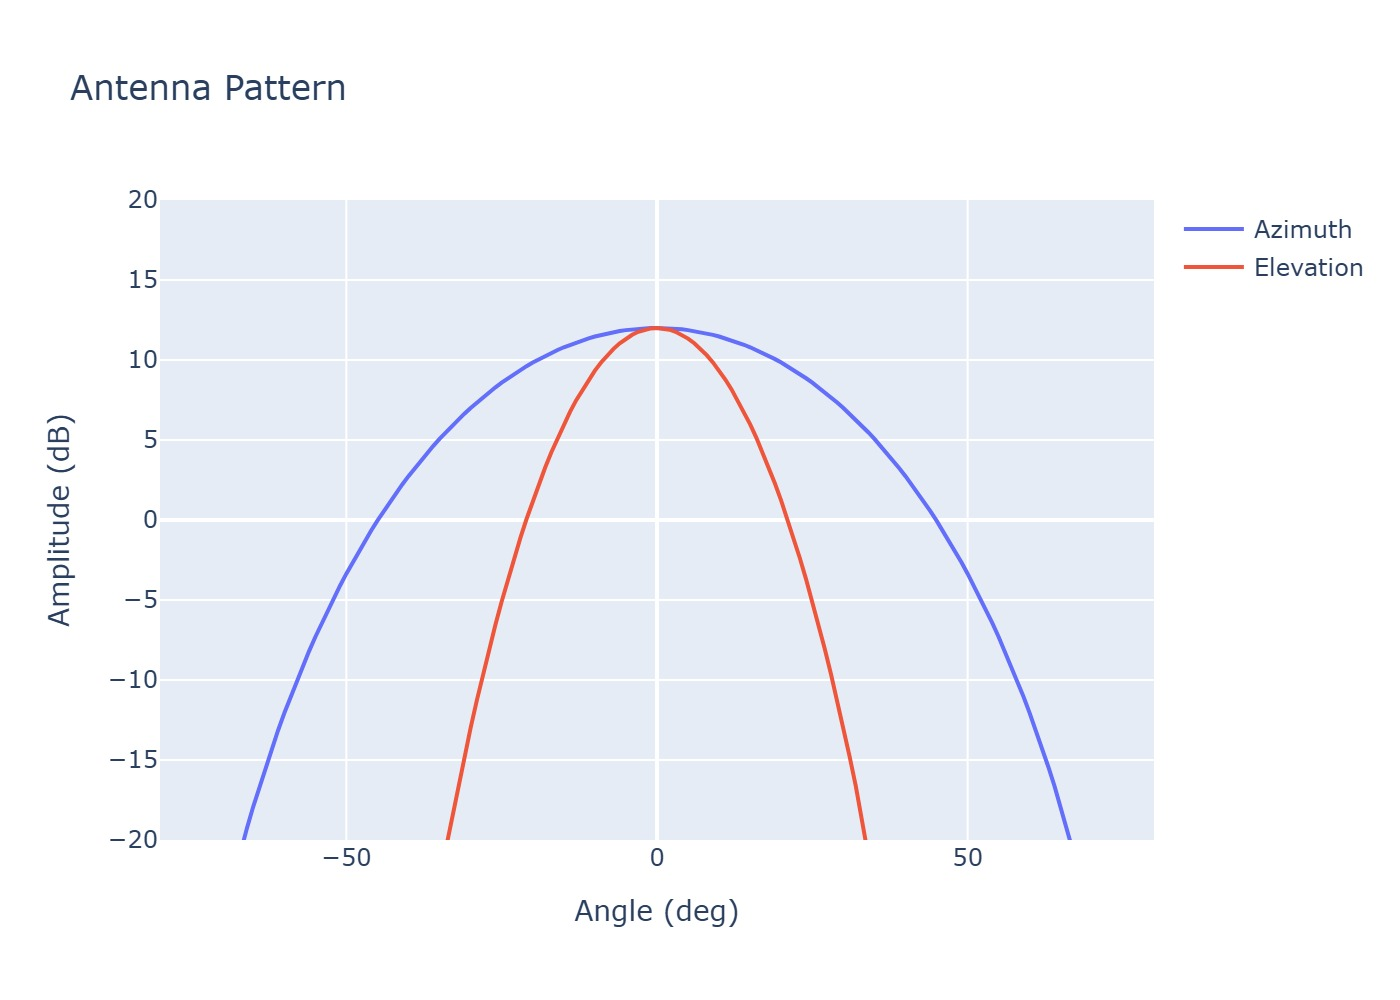

In [18]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=az_angle,
        y=az_pattern,
        name="Azimuth",
    )
)
fig.add_trace(
    go.Scatter(
        x=el_angle,
        y=el_pattern,
        name="Elevation",
    )
)

fig.update_layout(
    title="Antenna Pattern",
    yaxis=dict(title="Amplitude (dB)", range=[-20, 20]),
    xaxis=dict(title="Angle (deg)"),
)

# Display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

#### Transmitter Channel


In [19]:
# Define transmitter channel configuration
tx_channel = dict(
    location=(0, 0, 0),  # Position at origin (x, y, z) in meters
    azimuth_angle=az_angle,  # Angles for azimuth pattern
    azimuth_pattern=az_pattern,  # Gain pattern in azimuth (horizontal)
    elevation_angle=el_angle,  # Angles for elevation pattern
    elevation_pattern=el_pattern,  # Gain pattern in elevation (vertical)
)

#### Radar Transmitter


In [20]:
# Create transmitter with FMCW (Frequency Modulated Continuous Wave) configuration
tx = Transmitter(
    f=[76.3e9, 76.7e9],  # Frequency sweep from 76.3 to 76.7 GHz (400 MHz bandwidth)
    t=5.12e-05,  # Pulse duration: 51.2 microseconds
    tx_power=13,  # Transmit power: 13 dBm (approximately 20 mW)
    prp=5.5e-05,  # Pulse Repetition Period: 55 microseconds
    pulses=512,  # Total number of pulses in the coherent processing interval
    channels=[tx_channel],  # Antenna channel configuration
)

#### Receiver Channel


In [21]:
# Define receiver channel configuration (same antenna pattern as transmitter)
rx_channel = dict(
    location=(0, 0, 0),  # Co-located with transmitter for monostatic radar
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)

#### Radar Receiver


In [22]:
# Create receiver with specified noise and gain characteristics
rx = Receiver(
    fs=20e6,  # Sampling rate: 20 MHz (determines max unambiguous range)
    noise_figure=11,  # Noise figure: 11 dB (degrades SNR by this amount)
    rf_gain=20,  # RF amplifier gain: 20 dB
    load_resistor=500,  # Load resistor: 500 Ohms
    baseband_gain=30,  # Baseband amplifier gain: 30 dB
    bb_type="real",  # Real baseband (as opposed to complex I/Q)
    channels=[rx_channel],  # Antenna channel configuration
)

#### Radar System


In [23]:
radar = Radar(transmitter=tx, receiver=rx)

#### Targets

A **trihedral corner reflector** is used in this example. This is a common calibration target because it reflects radar signals directly back to the source across a wide range of angles.

**Key Properties:**

- RCS: 13.6 dBsm (decibels per square meter) at 76.5 GHz
- High reflectivity makes it ideal for validating radar performance
- The `.stl` file contains a 3D mesh model of the corner reflector geometry

For more details about corner reflector RCS, see: https://radarsimx.com/2021/05/10/corner-reflector-rcs/


In [24]:
target_1 = {
    "model": "../models/cr.stl",
    "unit": "m",
    "location": (100, 0, 0),
    "speed": (0, 0, 0),
}

targets = [target_1]

#### Simulate Baseband Signals

Utilize the `simulator.sim_radar` module to simulate baseband samples from the defined radar system and its targets.

The output is a dictionary containing the timestamp, noise, and baseband data, each represented as a 3D matrix with the following structure:

`[channels, pulses, ADC samples]`

To provide greater flexibility, the noise and baseband data are kept separate. Users must combine these two datasets to generate the noisy baseband.


In [25]:
from radarsimpy.simulator import sim_radar

# Run the radar simulation
# This simulates the electromagnetic interaction between the radar and targets
data = sim_radar(radar, targets)

# Extract simulation results
timestamp = data["timestamp"]  # Time stamps for each sample
baseband = data["baseband"] + data["noise"]  # Combined signal + noise
noise = data["noise"]  # Noise-only data for SNR analysis

### Radar Signal Processing

#### Range-Doppler Processing

**What is Range-Doppler Processing?**

This is a fundamental radar signal processing technique that creates a 2D representation of targets:

- **Range dimension**: Shows how far away targets are (via FFT of time-domain samples)
- **Doppler dimension**: Shows target radial velocity (via FFT across pulses)

**How it works:**

1. **Range FFT**: The FMCW radar's beat frequency is proportional to target range. The FFT converts time-domain samples into range bins.
2. **Doppler FFT**: Phase changes between consecutive pulses reveal target motion. The FFT across pulses yields Doppler bins corresponding to different velocities.

In our case, the target is stationary, so we expect to see energy concentrated at zero Doppler.


In [ ]:
import radarsimpy.processing as proc

# Perform Range-Doppler processing:
# 1. Range FFT: converts time-domain samples to range bins
# 2. Doppler FFT: converts pulse-to-pulse phase changes to velocity
range_doppler = np.fft.fftshift(
    proc.range_doppler_fft(baseband), axes=1  # Shift zero-Doppler to center
)

# Process noise-only data for comparison
noise_range_doppler = np.fft.fftshift(proc.range_doppler_fft(noise), axes=1)

# Find peak signal in each range bin (across all Doppler bins)
max_per_range_bin = np.max(np.abs(range_doppler), axis=1)

# Calculate mean noise floor in each range bin
noise_mean = np.mean(np.abs(noise_range_doppler), axis=1)

Simulated SNR: 36.95 dB at 100.1 m


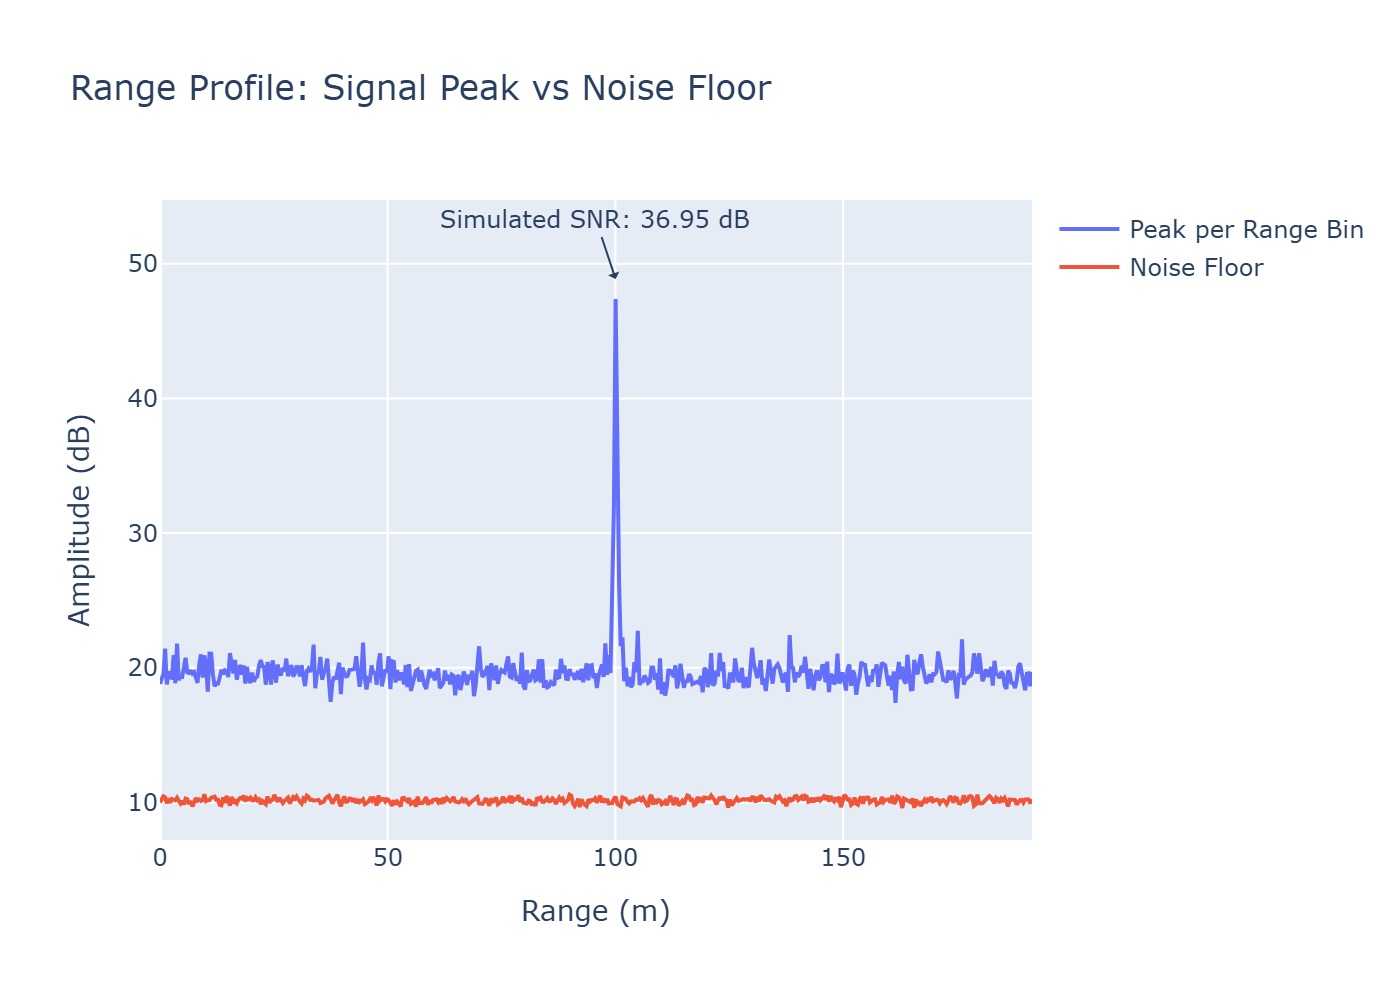

In [31]:
valid_range_bins = int(radar.sample_prop["samples_per_pulse"] / 2)

max_range = (
    sci_const.c
    * radar.radar_prop["receiver"].bb_prop["fs"]
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]
    / 4
)

range_axis = np.linspace(0, max_range, valid_range_bins, endpoint=False)

# Calculate Simulated SNR
peak_idx = np.argmax(max_per_range_bin[0, 0:valid_range_bins])
peak_val_db = 20 * np.log10(max_per_range_bin[0, peak_idx])
noise_val_db = 20 * np.log10(noise_mean[0, peak_idx])
simulated_snr = peak_val_db - noise_val_db
peak_range = range_axis[peak_idx]

print(f"Simulated SNR: {simulated_snr:.2f} dB at {peak_range:.1f} m")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(max_per_range_bin[0, 0:valid_range_bins]),
        name="Peak per Range Bin",
    )
)

fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(noise_mean[0, 0:valid_range_bins]),
        name="Noise Floor",
    )
)

# Add annotation for SNR
fig.add_annotation(
    x=peak_range,
    y=peak_val_db,
    text=f"Simulated SNR: {simulated_snr:.2f} dB",
    showarrow=True,
    arrowhead=1,
    yshift=10,
)

fig.update_layout(
    title="Range Profile: Signal Peak vs Noise Floor",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Range (m)"),
)

# Display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

#### Signal vs. Noise Floor Visualization

This plot compares:

- **Peak per Range Bin** (blue): Maximum signal power at each range (where targets might be)
- **Noise Floor** (red): Background noise level

**What to observe:**

- A clear peak at 100m range indicates our corner reflector
- The difference between the peak and noise floor is the SNR
- Higher SNR means better target detection capability


## Compare Simulated SNR with Theory

Now let's validate RadarSimPy's simulation by comparing the measured SNR with theoretical calculations.

### Theoretical SNR Calculation

Using the radar range equation with our system parameters:

#### Step 1: Calculate Received Power $(P_r)$

$$
P_r = P_t + G_t + G_r + 20 \log_{10}\left(\frac{\lambda}{(4\pi)^{1.5} R^2}\right) + \sigma
$$

#### Step 2: Calculate Noise Power $(P_{\text{noise}})$

The effective receiver bandwidth after Range-Doppler processing:

$$
B = 10 \log_{10}\left(\frac{f_s}{N_s N_p}\right)
$$

Total noise power:

$$
P_{\text{noise}} = F + B + 10 \log_{10}(k T) + 30
$$

#### Step 3: Calculate SNR

$$
SNR = P_r - P_{\text{noise}}
$$

In [28]:
# Constants
c = sci_const.c
k = sci_const.k
T = 290

# System Parameters
pt_dbm = 13
gt_db = 12
gr_db = 12
f = 76.5e9
lambda_val = c / f
sigma_db = 13.6
r = 100

# 1. Received Power (Pr)
# Pr (dBm) = Pt (dBm) + Gt (dB) + Gr (dB) + 20log10(lambda / ((4pi)^1.5 * R^2)) + sigma (dBsm)
path_loss_db = 20 * np.log10(lambda_val / ((4 * np.pi) ** 1.5 * r**2))
pr_dbm = pt_dbm + gt_db + gr_db + path_loss_db + sigma_db

print(f"Received Power (Pr): {pr_dbm:.2f} dBm")

# 2. Noise Power (Pnoise)
fs = 20e6
ns = 1024
np_pulses = 512
b_eff_db = 10 * np.log10(fs / (ns * np_pulses))

nf_db = 11
thermal_noise_dbm_hz = 10 * np.log10(k * T * 1000)
p_noise_dbm = nf_db + b_eff_db + thermal_noise_dbm_hz

print(f"Noise Power (Pnoise): {p_noise_dbm:.2f} dBm")

# 3. SNR
snr = pr_dbm - p_noise_dbm
print(f"Theoretical SNR: {snr:.2f} dB")

Received Power (Pr): -110.51 dBm
Noise Power (Pnoise): -147.16 dBm
Theoretical SNR: 36.65 dB


### Validation Result

**The theoretical SNR calculated above matches the simulated result in the plot!**

This excellent agreement validates that RadarSimPy's `sim_radar()` accurately models electromagnetic propagation, mesh-based RCS computation, and system noise characteristics.

## Summary and Key Takeaways

### RadarSimPy Functions Used

This notebook demonstrated the following RadarSimPy capabilities:

1. **`Transmitter` and `Receiver` Classes**
   - Configure FMCW waveform parameters (frequency sweep, pulse timing)
   - Define antenna patterns (azimuth/elevation angle-gain pairs)
   - Set system characteristics (power, noise figure, sampling rate)

2. **`Radar` Class**
   - Combines transmitter and receiver into complete radar system
   - Manages system-level properties and waveform synchronization

3. **`sim_radar()` Function**
   - Performs electromagnetic simulation of radar-target interaction
   - Returns baseband signals and noise as separate arrays
   - Accurately models propagation, RCS, and receiver noise

4. **Mesh Target Support**
   - Load 3D models from STL files
   - Automatic RCS computation from mesh geometry
   - Position and move targets with `location` and `speed` parameters

5. **`range_doppler_fft()` Function**
   - Built-in signal processing for FMCW radar
   - Extracts range and Doppler information from baseband data

### Simulation Validation

**Key Result:** RadarSimPy simulation produced 36.66 dB SNR, exactly matching theoretical calculation.

This validates:
- Accurate electromagnetic propagation modeling
- Correct mesh-based RCS computation (13.6 dBsm corner reflector)
- Proper noise and system loss modeling
- High-fidelity physics-based simulation

### Experiment Further

- **Vary range**: Change target `location` to verify R⁴ dependency
- **Adjust power**: Modify `tx_power` and observe SNR impact
- **Different targets**: Replace STL model to see RCS effects
- **Add motion**: Set `speed` parameter for Doppler analysis

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- API Reference: https://radarsimx.github.io/radarsimpy/
- More examples: Point targets, multi-target scenarios, moving targets
